# LSTM

## Caricamento del dataframe

In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from torch.utils.tensorboard import SummaryWriter

from scipy.stats import mode

import os
import shutil
import glob

main_folder = "../data"

folder = "./runs/LSTM_1"

try:
    shutil.rmtree(folder, ignore_errors=True)
except:
    pass

try:
    os.mkdir(folder)
except:
    pass

writer = SummaryWriter(folder)

## Train - Validation - Test

In [2]:
LABELS = [
    "No_action",
    "Prendi",
    "Rilascia",
    "Premi"
]

In [3]:
class2idx = {
    "No_action": 0,
    "Prendi": 1,
    "Rilascia": 2,
    "Premi": 3
}

idx2class = {v: k for k, v in class2idx.items()}

In [4]:
def join_csv(folder_set, filename):
    csv:list = []

    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)

    columns:bool = True
    with open(filename, "w") as f:
        for fcsv in csv:
            with open(fcsv, "r") as fc:
                if columns:
                    f.writelines(fc.readlines())
                    columns = False
                fc.readline()
                f.writelines(fc.readlines())

In [5]:
def create_set(folder_set, filename) -> list:
    csv:list = []
    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)
    columns:bool = True
    colname = []
    data = []
    target = []
    for fcsv in csv:
        data_video = []
        target_video = []
        with open(fcsv, "r") as fc:
            if columns:
                colname = [(name) for name in fc.readline().split(",")]
                colname[-1] = colname[-1][:-1]
                columns = False
            else:
                fc.readline()
            for row in fc.readlines():
                split_row = row.split(",")
                data_video.append(split_row[:-1])
                target_video.append(class2idx[split_row[-1][:-1]])
        data.append(np.array(data_video).astype(float))
        target.append(np.array(target_video).astype(int))
    return (np.array(data, dtype=object), np.array(target, dtype=object), colname)

In [6]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

train_array, train_label_array, colname = create_set(folder_set[0][0], folder_set[0][1])
test_array, test_label_array, colname = create_set(folder_set[1][0], folder_set[1][1])
val_array, val_label_array, colname = create_set(folder_set[2][0], folder_set[2][1])

In [7]:
print(train_array.shape, train_label_array.shape, test_array.shape, test_label_array.shape, val_array.shape, val_label_array.shape)

(38,) (38,) (10,) (10,) (8,) (8,)


In [8]:
for elem, label in zip(train_array, train_label_array):
    print(elem.shape, label.shape)
    print(type(elem), type(label))

(1115, 156) (1115,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1009, 156) (1009,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1070, 156) (1070,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3598, 156) (3598,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1975, 156) (1975,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(788, 156) (788,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1867, 156) (1867,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1100, 156) (1100,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1489, 156) (1489,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2210, 156) (2210,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1680, 156) (1680,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2045, 156) (2045,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1164, 156) (1164,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1434, 156) (1434,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(842, 156) (842,)
<class 'numpy.ndarray'> <class '

In [9]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

for f_set, filename in folder_set:
    join_csv(f_set, filename)
    
train = pd.read_csv(main_folder + "/train.csv")
test = pd.read_csv(main_folder + "/test.csv")
val = pd.read_csv(main_folder + "/val.csv")

train['TARGET'].replace(class2idx, inplace=True)
test['TARGET'].replace(class2idx, inplace=True)
val['TARGET'].replace(class2idx, inplace=True)

In [10]:
train.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
test.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
val.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
print(train.shape[0], test.shape[0], val.shape[0])

56125 11860 9656


Si separano le colonne delle features dall'etichetta.

In [14]:
train_label = train["TARGET"]
test_label = test["TARGET"]
val_label = val["TARGET"]

del train["TARGET"]
del test["TARGET"]
del val["TARGET"]

## Visualizzazione della distribuzione delle classi in Train, Val e Test

In [15]:
def get_class_distribution(obj):
    count_dict = {
        "No_action": 0,
        "Prendi": 0,
        "Rilascia": 0,
        "Premi": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['No_action'] += 1
        elif i == 1: 
            count_dict['Prendi'] += 1
        elif i == 2: 
            count_dict['Rilascia'] += 1
        elif i == 3: 
            count_dict['Premi'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

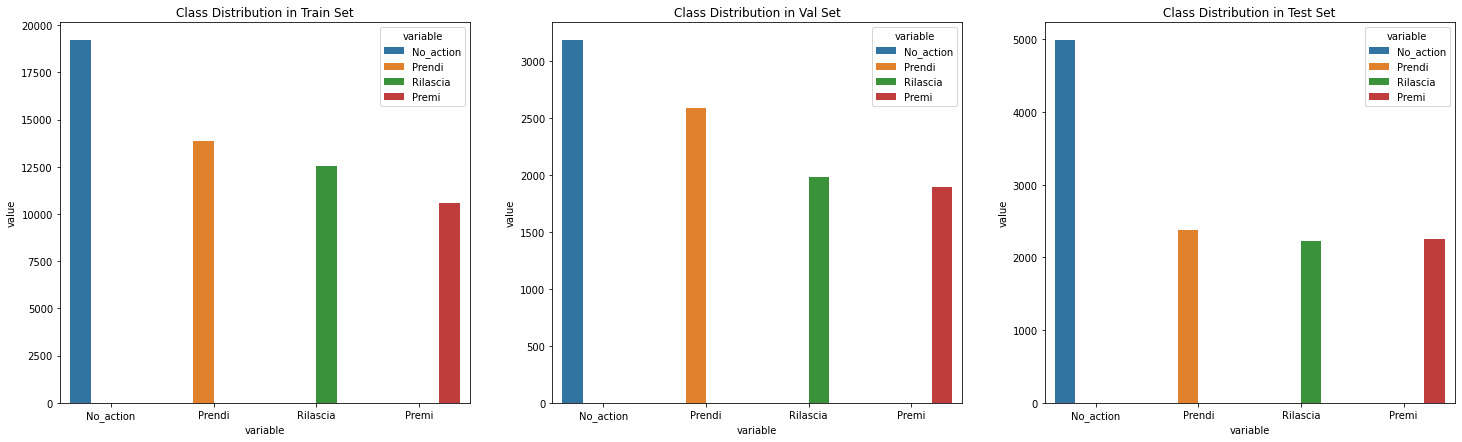

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [17]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [18]:
window_size = 1

In [19]:
def create_dataset(dataset, target, window_size = 2):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        dataX.append(dataset[i:(i + window_size)])
        dataY.append(target[i:(i + window_size + 1)].values[0])
    return np.array(dataX), np.array(dataY)

In [20]:
train_X, train_Y = create_dataset(train, train_label, window_size)
train_dataset_w = ClassifierDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long())

test_X, test_Y = create_dataset(test, test_label, window_size)
test_dataset_w = ClassifierDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long())

val_X, val_Y = create_dataset(val, val_label, window_size)
val_dataset_w = ClassifierDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_Y).long())

In [51]:
class ClassifierDataset(Dataset):
    
    def __init__(self, array, label, index_data, window):
        self.index_data = index_data
        self.array = array
        self.label = label
        self.window = window
        
    def __getitem__(self, index):
        file_index = self.index_data[index][0].tolist()
        i = self.index_data[index][1]
        j = self.index_data[index][2]
        if i == j:
            x_data = [self.array[file_index][i]] * self.window
            y_data = self.label[file_index][i]
            X = torch.from_numpy(np.array(x_data).astype(float)).float()
            Y = torch.from_numpy(np.array([y_data]).astype(int)).long()
            return X, Y
        elif j-i < self.window-1:
            x_data = [self.array[file_index][i]] * (self.window-j)
            x_data.extend(self.array[file_index][(i+1):(j+1)])
            x_data = np.array(x_data).astype(float)
        else:
            x_data = self.array[file_index][i:(j+1)]
            k = j-1
            while len(x_data) > self.window:
                x_data = self.array[file_index][i:(k+1)]
                k -= 1
        X = torch.from_numpy(x_data).float()
        y_data = self.label[file_index][i:(j+1)]
        y_mode = mode(y_data)[0][0]
        Y = torch.from_numpy(np.array([y_mode])).long()
        return X, Y
        
    def __len__ (self):
        return len(self.index_data)

In [52]:
def create_dataset(array_data, label_data, window):
    X = []
    array_data_len = len(array_data)
    for index, array, label in zip(range(array_data_len), array_data, label_data):
        l = array.shape[0]
        i = 0
        while l - i >= window:
            j = i + window
            index_batch = np.array([index, i, j]).astype(int)
            X.append(index_batch)
            i += 1
    X_batch = torch.from_numpy(np.array(X).astype(int))
    return ClassifierDataset(array_data, label_data, X_batch, window)

In [53]:
def create_dataset2(array_data, label_data, window):
    X = []
    files_num = len(array_data)
    for index, array, label in zip(range(files_num), array_data, label_data):
        l = array.shape[0]
        i = -1
        w = [0] * window
        while i < l:
            i += 1 
            w.pop(0)
            w.append(i)
            index_window = np.array([index, w[0], i]).astype(int)
            X.append(index_window)
    X_data = torch.from_numpy(np.array(X).astype(int))
    return ClassifierDataset(array_data, label_data, X_data, window)

## Weighted Sampling

Poiché c'è uno squilibrio di classe, utilizziamo la suddivisione stratificata per creare i nostri set di train, convalida e test.

In [54]:
target_list = []

for _, t in train_dataset_w:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

Quindi, otteniamo il conteggio di tutte le classi nel nostro set di allenamento.  Usiamo il reciproco di ogni conteggio per ottenere il suo peso.  Ora che abbiamo calcolato i pesi per ogni classe, possiamo procedere.

In [55]:
class_count = [i for i in get_class_distribution(train_label).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)

tensor([5.2129e-05, 7.2166e-05, 7.9885e-05, 9.4634e-05])


WeightedRandomSampler prevede un peso per ogni campione.  Lo usiamo come segue.

In [56]:
class_weights_all = class_weights[target_list]

Infine, inizializziamo il nostro WeightedRandomSampler.  Lo chiameremo nel nostro dataloader in seguito.

In [57]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

## Parametri del modello

In [70]:
EPOCHS = 50
window = 330
BATCH_SIZE = 512
LEARNING_RATE = 0.04
NUM_LAYER = 1
NUM_HIDDEN = 78
NUM_FEATURES = 156
NUM_CLASSES = 4

In [71]:
train_dataset = create_dataset(train_array, train_label_array, window)
test_dataset = create_dataset2(test_array, test_label_array, window)
val_dataset = create_dataset2(val_array, val_label_array, window)

In [72]:
print(train_dataset.index_data.shape)
print(len(train_dataset))
print(test_dataset.index_data.shape)
print(len(test_dataset))
print(val_dataset.index_data.shape)
print(len(val_dataset))

torch.Size([43623, 3])
43623
torch.Size([11870, 3])
11870
torch.Size([9664, 3])
9664


In [73]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## Rete Neurale LSTM

In [74]:
class LSTM(nn.Module):
    def __init__(self, input_size, window, output_size, hidden_layer_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.regressor = nn.Linear(hidden_layer_size, output_size)
        #self.bn = nn.BatchNorm1d(window)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h0 = hidden[0]
            c0 = hidden [1]
        else:
            h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
        #x = self.bn(x.view(1, len(x), -1))
        #x = self.bn(x)
        h, hn = self.lstm(x, (h0, c0))
        h = h.squeeze(1)
        h = self.regressor(h[:,-1,:])        
        return h, hn

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
device

device(type='cuda')

In [77]:
model = LSTM(input_size=NUM_FEATURES, window=window, output_size=NUM_CLASSES, hidden_layer_size=NUM_HIDDEN, num_layers=NUM_LAYER)
model.to(device)

#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
print(model)

LSTM(
  (lstm): LSTM(156, 78, batch_first=True)
  (regressor): Linear(in_features=78, out_features=4, bias=True)
)


## Train the model

Prima di iniziare il nostro addestramento, definiamo una funzione per calcolare la precisione per epoca.

Questa funzione accetta y_pred e y_test come argomenti di input.  Quindi applichiamo log_softmax a y_pred ed estraiamo la classe che ha una probabilità maggiore.

Successivamente, confrontiamo le classi previste e le classi effettive per calcolare l'accuratezza.

In [78]:
def accuracy(y_pred, y_true):
    return accuracy_score(y_true, y_pred) * 100

In [79]:
def f1_s(y_pred, y_true):
    return f1_score(y_true, y_pred, average=None, zero_division=1, labels=[0,1,2,3])

In [80]:
print('test_data_size:',test_dataset.index_data.size())
print('test_label_size:',test_dataset.index_data.size())
n_data_size_test = test_dataset.index_data.size()[0]
print('n_data_size_test:',n_data_size_test)

print('train_data_size:',train_dataset.index_data.size())
print('train_label_size:',train_dataset.index_data.size())
n_data_size_train = train_dataset.index_data.size()[0]
print('n_data_size_train:',n_data_size_train)

print('val_data_size:',val_dataset.index_data.size())
print('val_label_size:',val_dataset.index_data.size())
n_data_size_val = val_dataset.index_data.size()[0]
print('n_data_size_val:',n_data_size_val)

test_data_size: torch.Size([11870, 3])
test_label_size: torch.Size([11870, 3])
n_data_size_test: 11870
train_data_size: torch.Size([43623, 3])
train_label_size: torch.Size([43623, 3])
n_data_size_train: 43623
val_data_size: torch.Size([9664, 3])
val_label_size: torch.Size([9664, 3])
n_data_size_val: 9664


Definiremo anche 2 dizionari che memorizzeranno l'accuratezza/epoca e la perdita/epoca sia per il treno che per i set di convalida.

In [81]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

f1_score_No_action = {
    'train': [],
    "val": []
}

f1_score_Prendi = {
    'train': [],
    "val": []
}

f1_score_Rilascia = {
    'train': [],
    "val": []
}

f1_score_Premi = {
    'train': [],
    "val": []
}

In [82]:
print("Begin training.")

print_every = 5

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_f1_No_action = 0
    train_epoch_f1_Prendi = 0
    train_epoch_f1_Rilascia = 0
    train_epoch_f1_Premi = 0
    train_pred_lab = []
    train_true_lab = []
    
    model.train()
    
    hidden_train = None
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        y_train_batch = torch.squeeze(y_train_batch)
        optimizer.zero_grad()
        
        y_train_pred, _ = model(X_train_batch, hidden_train)

        #h0, c0 = hidden_train
        #h0.detach_(), c0.detach_()
        #hidden_train = (h0, c0)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_pred_lab.append(y_train_pred)
        train_true_lab.append(y_train_batch)
        
        train_loss.backward()
        optimizer.step()
                
        train_epoch_loss += train_loss.item()
        
    y_pred_tags = []
    y_true_tags = []
    for (p, t) in zip(train_pred_lab, train_true_lab):
        _, y_tags = torch.max(p, dim = 1)
        y_pred_tags.extend(y_tags.tolist())
        y_true_tags.extend(t.tolist())
    
    train_acc = accuracy(y_pred_tags, y_true_tags)
    train_f1 = f1_s(y_pred_tags, y_true_tags)
    
    train_epoch_acc += train_acc.item()
    train_epoch_f1_No_action += train_f1[0].item()
    train_epoch_f1_Prendi += train_f1[1].item()
    train_epoch_f1_Rilascia += train_f1[2].item()
    train_epoch_f1_Premi += train_f1[3].item()
        
    if e % print_every == 0:
        
        # VALIDATION    
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0
            val_epoch_f1 = 0
            val_epoch_f1_No_action = 0
            val_epoch_f1_Prendi = 0
            val_epoch_f1_Rilascia = 0
            val_epoch_f1_Premi = 0
            val_pred_lab = []
            val_true_lab = []

            #hidden_valid = (h0, c0)
            hidden_valid = None

            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                y_val_pred, _ = model(X_val_batch, hidden_valid)

                val_loss = criterion(y_val_pred, y_val_batch[0])
                val_pred_lab.append(y_val_pred)
                val_true_lab.append(y_val_batch[0])
                
                val_epoch_loss += val_loss.item()
                
            y_pred_tags = []
            y_true_tags = []
            for (p, t) in zip(val_pred_lab, val_true_lab):
                _, y_tags = torch.max(p, dim = 1)
                y_pred_tags.extend(y_tags.tolist())
                y_true_tags.extend(t.tolist())
                
            val_acc = accuracy(y_pred_tags, y_true_tags)
            val_f1 = f1_s(y_pred_tags, y_true_tags)

            val_epoch_acc += val_acc.item()
            val_epoch_f1_No_action += val_f1[0].item()
            val_epoch_f1_Prendi += val_f1[1].item()
            val_epoch_f1_Rilascia += val_f1[2].item()
            val_epoch_f1_Premi += val_f1[3].item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))        
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc)
        accuracy_stats['val'].append(val_epoch_acc)
        f1_score_No_action['train'].append(train_epoch_f1_No_action)
        f1_score_No_action['val'].append(val_epoch_f1_No_action)
        f1_score_Prendi['train'].append(train_epoch_f1_Prendi)
        f1_score_Prendi['val'].append(val_epoch_f1_Prendi)
        f1_score_Rilascia['train'].append(train_epoch_f1_Rilascia)
        f1_score_Rilascia['val'].append(val_epoch_f1_Rilascia)
        f1_score_Premi['train'].append(train_epoch_f1_Premi)
        f1_score_Premi['val'].append(val_epoch_f1_Premi)

#         writer.add_scalars("Loss/train_val", {
#             "train": train_epoch_loss/len(train_loader),
#             "val": val_epoch_loss/len(val_loader),
#         }, e)
#         writer.add_scalars("Acc/train_val", {
#             "train": train_epoch_acc,
#             "val": val_epoch_acc,
#         }, e)
#         writer.add_scalars("F1-No_action/train_val", {
#             "train": train_epoch_f1_No_action,
#             "val": val_epoch_f1_No_action,
#         }, e)
#         writer.add_scalars("F1-Prendi/train_val", {
#             "train": train_epoch_f1_Prendi,
#             "val": val_epoch_f1_Prendi,
#         }, e)
#         writer.add_scalars("F1-Rilascia/train_val", {
#             "train": train_epoch_f1_Rilascia,
#             "val": val_epoch_f1_Rilascia,
#         }, e)
#         writer.add_scalars("F1-Premi/train_val", {
#             "train": train_epoch_f1_Premi,
#             "val": val_epoch_f1_Premi,
#         }, e)
#         writer.flush()
        print(f'Epoch {e+0:03}:\
              | Train Loss: {train_epoch_loss/len(train_loader)}\
              | Val Loss: {val_epoch_loss/len(val_loader)}\
              | Train Acc: {train_epoch_acc}\
              | Val Acc: {val_epoch_acc}\
              | Train F1-No_action: {train_epoch_f1_No_action}\
              | Val F1-No_action: {val_epoch_f1_No_action}\
              | Train F1-Prendi: {train_epoch_f1_Prendi}\
              | Val F1-Prendi: {val_epoch_f1_Prendi}\
              | Train F1-Rilascia: {train_epoch_f1_Rilascia}\
              | Val F1-Rilascia: {val_epoch_f1_Rilascia}\
              | Train F1-Premi: {train_epoch_f1_Premi}\
              | Val F1-Premi: {val_epoch_f1_Premi}')
# writer.close()
print("Done.")

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 005:              | Train Loss: 1.23542              | Val Loss: 1.29556              | Train Acc: 42.989              | Val Acc: 37.583              | Train F1-No_action: 0.61748              | Val F1-No_action: 0.57690              | Train F1-Prendi: 0.20567              | Val F1-Prendi: 0.10758              | Train F1-Rilascia: 0.00000              | Val F1-Rilascia: 0.00000              | Train F1-Premi: 0.30015              | Val F1-Premi: 0.16173
Epoch 010:              | Train Loss: 1.18701              | Val Loss: 1.29599              | Train Acc: 47.603              | Val Acc: 39.021              | Train F1-No_action: 0.69580              | Val F1-No_action: 0.62789              | Train F1-Prendi: 0.19094              | Val F1-Prendi: 0.07654              | Train F1-Rilascia: 0.00053              | Val F1-Rilascia: 0.00000              | Train F1-Premi: 0.42197              | Val F1-Premi: 0.31287
Epoch 015:              | Train Loss: 1.27632              | Val Loss: 1.2

## Visualizzazione Loss e Accuracy

Per tracciare i grafici delle linee di perdita e accuratezza, creiamo nuovamente un dataframe dai dizionari precision_stats e loss_stats.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

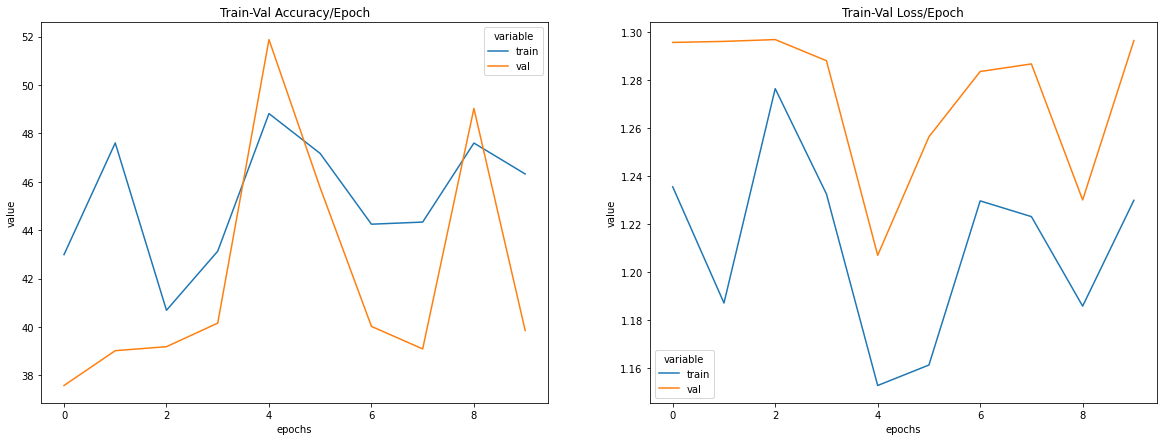

In [85]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_No_action = pd.DataFrame.from_dict(f1_score_No_action).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Prendi = pd.DataFrame.from_dict(f1_score_Prendi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Rilascia = pd.DataFrame.from_dict(f1_score_Rilascia).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Premi = pd.DataFrame.from_dict(f1_score_Premi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val F1-Prendi/Epoch')

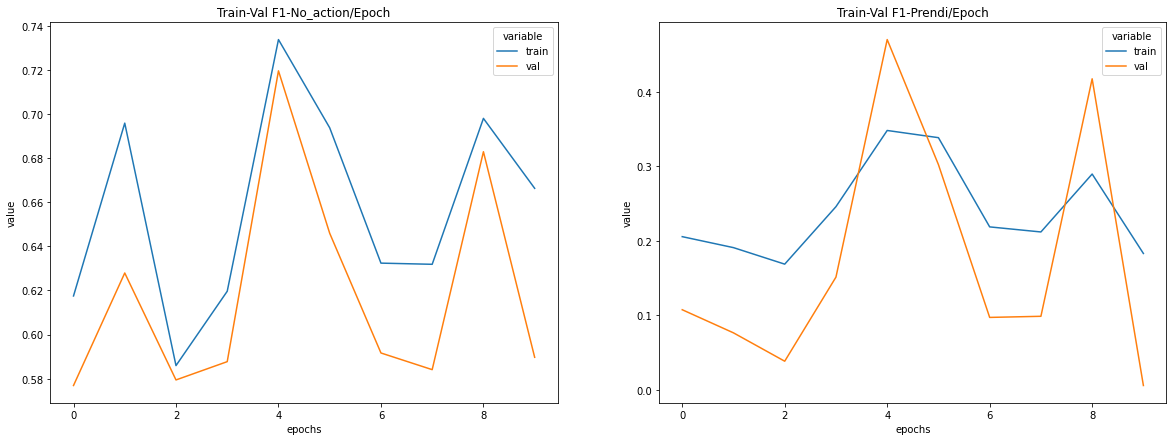

In [86]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_No_action, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-No_action/Epoch')
sns.lineplot(data=train_val_f1_Prendi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Prendi/Epoch')

Text(0.5, 1.0, 'Train-Val F1-Premi/Epoch')

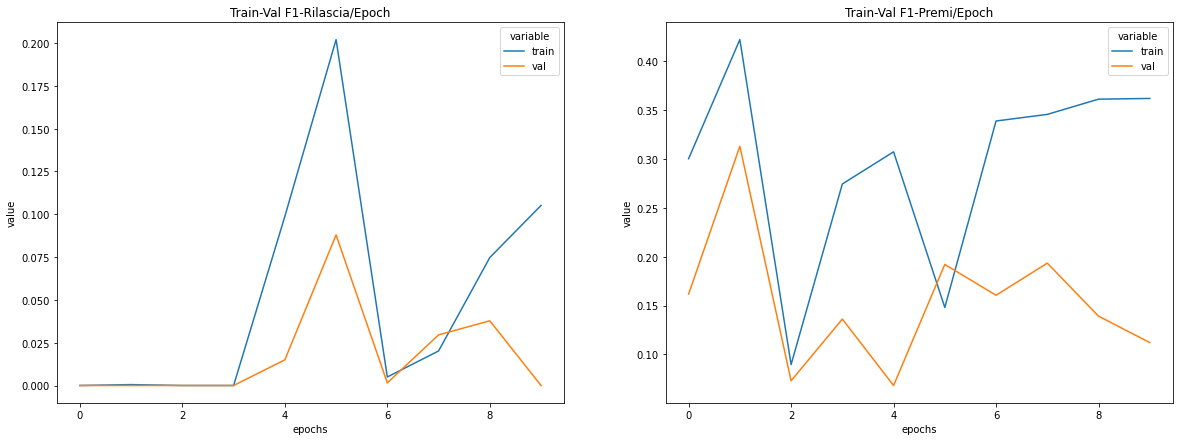

In [87]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_Rilascia, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-Rilascia/Epoch')
sns.lineplot(data=train_val_f1_Premi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Premi/Epoch')

## Test the model

Al termine dell'addestramento, dobbiamo testare come si è comportato il nostro modello.  Nota che abbiamo usato model.eval() prima di eseguire il nostro codice di test.  Per dire a PyTorch che non vogliamo eseguire la retropropagazione durante l'inferenza, usiamo torch.no_grad(), proprio come abbiamo fatto per il ciclo di convalida sopra.

Iniziamo definendo un elenco che conterrà le nostre previsioni.  Quindi eseguiamo il ciclo dei nostri batch utilizzando test_loader.

In [88]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred, _ = model(X_batch)
        _, y_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_tags.cpu().tolist())
        y_true_list.append(y_batch[0][0].tolist())

In [89]:
len(y_pred_list) == len(y_true_list)

True

## Confusion Matrix

Creiamo un dataframe dalla matrice di confusione e lo tracciamo come una mappa di calore utilizzando la libreria Seaborn.

<AxesSubplot:>

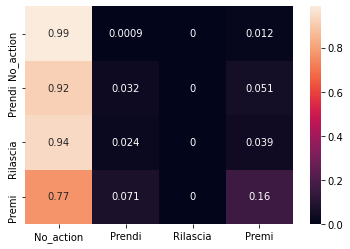

In [90]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [91]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.59      0.99      0.74      6662
           1       0.34      0.03      0.06      2225
           2       0.00      0.00      0.00      1612
           3       0.46      0.16      0.24      1371

    accuracy                           0.58     11870
   macro avg       0.35      0.29      0.26     11870
weighted avg       0.45      0.58      0.45     11870



C:\Users\semin\anaconda3\envs\ailab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\semin\anaconda3\envs\ailab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\semin\anaconda3\envs\ailab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
#torch.save(model.state_dict(), main_folder + "/mymodel_lstm.pt")

In [93]:
#nmodel = LSTM(input_size=NUM_FEATURES, window=window, output_size=NUM_CLASSES, hidden_layer_size=NUM_HIDDEN, num_layers=NUM_LAYER)
#nmodel.to(device)
#nmodel.load_state_dict(torch.load("../data/mymodel_lstm.pt"))
#print(nmodel)